# Evaluate the model

## Import libraries

In [12]:
%load_ext autoreload
%autoreload 2

from get_loader import get_loader
from models import Encoder, Decoder
import torch
import torch.nn as nn
from utils import *
from PIL import Image
from nltk.translate import bleu_score

In [2]:
IMAGE_PATH = '../Datasets/coco/images/val2017' 
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'

FREQ_THRESHOLD = 5
CAPS_PER_IMAGE = 5
BATCH_SIZE = 1
SHUFFLE = True
MODE = 'test'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


## Model 3 - sports "v1"

This has same parameters as model 2, but data set is restricted to images showing sports categories.

Original model was run with vocab saved in:
* `sportsword2idx.json`

And model saved in:
* `model/model_sport_v2` folder


In [53]:
CAPTIONS_NAME = 'sports_v1'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 10k/2k/1k\n' \
                'frequency threshold: 5\n' \
                'batch size: 128\n' \
                'embed size: 1024'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v1'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4690.
Length of vocabulary: 2110


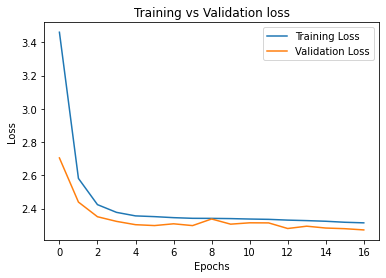

In [54]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

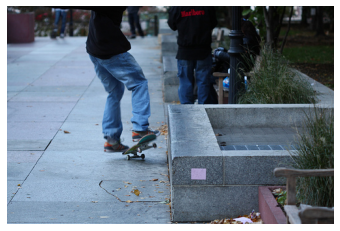

Predicted caption: a man is riding a skateboard on a street .
Original Captions:
0. A man riding on a skateboard on the sidewalk.
1. a kid riding on a skateboard on the cement
2. There is a skateboarder riding his board on the sidewalk
3. A skateboarder with one fut on a skateboard raising it up.
4. A pavement where a person foot are seen having skates. 


In [55]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [7]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(**evaluation_params)

CPU times: user 19min 13s, sys: 1min 54s, total: 21min 8s
Wall time: 8min 11s


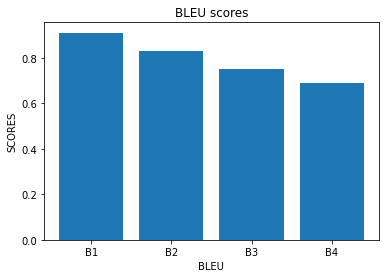

In [8]:
plot_bleu_score_bar(b1_avg, b2_avg, b3_avg, b4_avg)

In [48]:
bleu_score = [b1_avg, b2_avg, b3_avg, b4_avg]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

### The dreaded beam search

In [20]:
from beam_search import BeamSearch

In [21]:
encoder.to(device);
encoder.eval()

transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = transformer(img)
img = img.to(device)

features = encoder(img.unsqueeze(0)).unsqueeze(1)

In [22]:
beam = BeamSearch(decoder=decoder,
                  features=features,
                  word2idx=word2idx,
                  k=3, 
                  max_len=20)

sentence, score = beam.generate_caption()

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.DoubleTensor instead (while checking arguments for embedding)

## Model 4 - sports "v3"

Some adaptations to sports v2: embedding size down to 512 from 1024, a larger train set of 15k instead of 10k images, and a frequency theshold of 4 for inclusion in the vocab. Most models training on the full coco training set seem to use a frequency threshold of 5, so we thought trying a threshold of 4 was worth while given that we're using 15k instead of 128k images as the training set.

Original model was run with vocab saved in:
* `sports_v2word2idx.json`

And model saved in:
* `model/model_sport_v3` folder


In [22]:
CAPTIONS_NAME = 'sports_v2'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 4\n' \
                'batch size: 128\n' \
                'embed size: 512' 
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v3'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4690.
Length of vocabulary: 2921


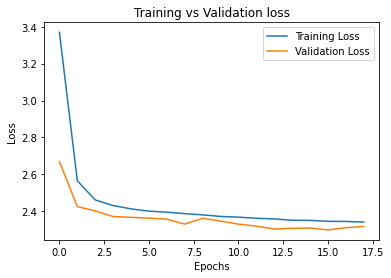

In [23]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

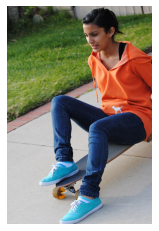

Predicted caption: a man holding a skateboard in a park .
Original Captions:
0. Cute girl sitting on a skateboard in the driveway 
1. a girl sitting on a skateboard in the driveway
2. A girl is sitting on a skateboard outside
3. A girl is sitting on the sidewalk on her skate board.
4. A girl in an orange sweater is sitting on a skateboard.


In [24]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [25]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(**evaluation_params)

CPU times: user 19min 34s, sys: 1min 55s, total: 21min 29s
Wall time: 9min 5s


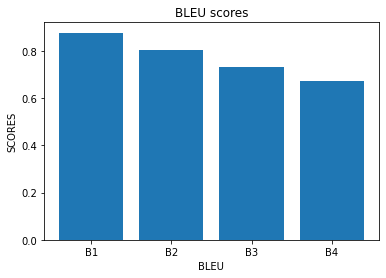

In [26]:
plot_bleu_score_bar(b1_avg, b2_avg, b3_avg, b4_avg)

In [47]:
bleu_score = [b1_avg, b2_avg, b3_avg, b4_avg]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 5 - sports_v4

This has same parameters as model 2, but data set is restricted to images showing sports categories.

In [29]:
CAPTIONS_NAME = 'sports_v4'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/2k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512\n' \
                'vocab build using entire train2017 captions data'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v4'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4690.
Length of vocabulary: 10192


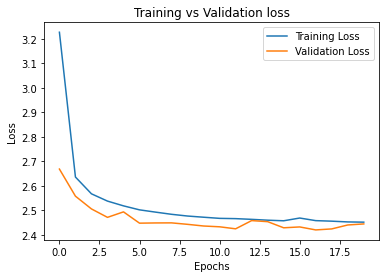

In [30]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

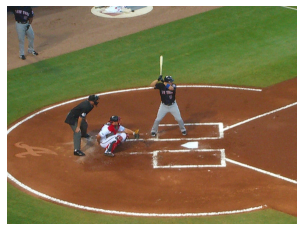

Predicted caption: a baseball player is swinging a bat at a baseball game .
Original Captions:
0. The baseball player is participating in an intense game,
1. A baseball game in progress with the batter up to plate.
2. A professional baseball holding his bat at home base.
3. Baseball players prepare for the next pitch in a game.
4. A batter up to bat at a baseball game.


In [31]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [32]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(**evaluation_params)

/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


CPU times: user 19min 35s, sys: 1min 50s, total: 21min 26s
Wall time: 9min 40s


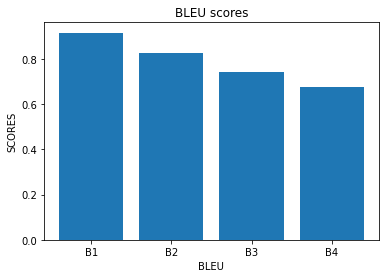

In [33]:
plot_bleu_score_bar(b1_avg, b2_avg, b3_avg, b4_avg)

In [34]:
bleu_score = [b1_avg, b2_avg, b3_avg, b4_avg]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 6 - sports_v5

All the sport data - 28k training size.

In [35]:
CAPTIONS_NAME = 'sports_v5'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 20k/3k/1k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 1024'   
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v5'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4690.
Length of vocabulary: 2988


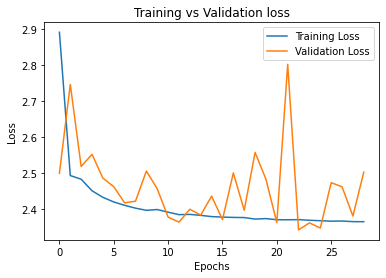

In [36]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

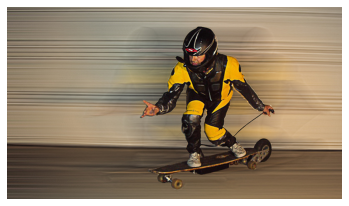

Predicted caption: a man riding a skateboard down a ramp .
Original Captions:
0. A person in a helmet is riding a skateboard.
1. Man in yellow and black body suit on skateboard.
2. A man with a helmet on riding on an electrical skateboard. 
3. A skateboarder demonstrates on his skateboard that has a large wheel in the back.
4. A man on a long exposure picture riding an electric skateboard.


In [37]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [38]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(**evaluation_params)

/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


CPU times: user 19min 1s, sys: 1min 48s, total: 20min 49s
Wall time: 9min 11s


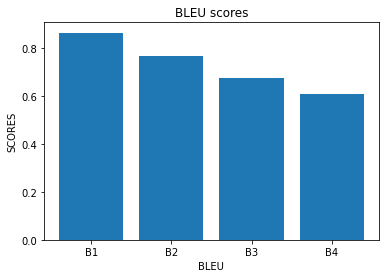

In [39]:
plot_bleu_score_bar(b1_avg, b2_avg, b3_avg, b4_avg)

In [40]:
bleu_score = [b1_avg, b2_avg, b3_avg, b4_avg]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 7 - everything

This has same parameters as model 2, but data set is restricted to images showing sports categories.

In [41]:
CAPTIONS_NAME = 'everything'
MODEL_SUMMARY = 'images sampled from entire train2017 data set\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512'    # NEEDS UPDATING ########
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_everything'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 24760.
Length of vocabulary: 10192


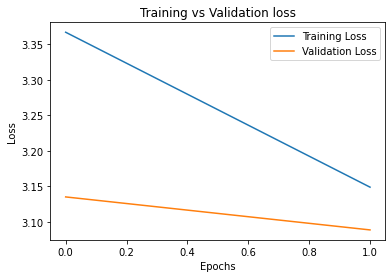

In [42]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

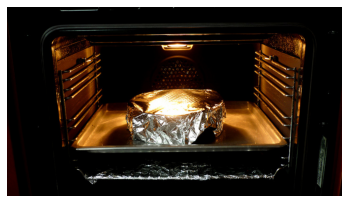

Predicted caption: a bathroom with a toilet and a sink .
Original Captions:
0. there is a round pan covered with aluminum in the stove
1. The oven contains a dish that is covered with tin foil.
2. A casserole covered in foil is inside an oven.
3. A dish covered in aluminum foil is baking in an oven. 
4. a pot of food cooking in an oven


In [43]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [44]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(**evaluation_params)

/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


CPU times: user 1h 45min 29s, sys: 9min 50s, total: 1h 55min 19s
Wall time: 51min 27s


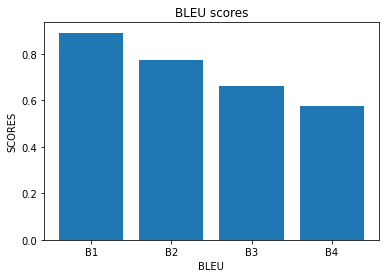

In [45]:
plot_bleu_score_bar(b1_avg, b2_avg, b3_avg, b4_avg)

In [46]:
bleu_score = [b1_avg, b2_avg, b3_avg, b4_avg]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

In [138]:
def calc_captions(encoder, decoder, loader, dataset, device):
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()

    caption_refs = []
    caption_hypos = []
    
    for i, batch in enumerate(loader):
        idx, image, caption = batch
        image = image.to(device)
        features = encoder(image).unsqueeze(1)
        outputs = decoder.predict(features, dataset.vocab.word2idx, 20)
        cap = [dataset.vocab.idx2word[word] for word in outputs]
        cap = cap[1:-1]
        result = ''
        for word in cap:
            result += word + ' '

        # result += '.'
        hypo = result.strip().lower().split()

        references = dataset.get_captions(dataset.img_deque[idx[0]][0])
        references = [ref.strip().lower().split() for ref in references]

        caption_refs.append(references)
        caption_hypos.append(hypo)

    return caption_refs, caption_hypos



In [154]:
from utils import evaluate_bleu_score2
b1_avg, b2_avg, b3_avg, b4_avg = evaluate_bleu_score(encoder, decoder, test_loader, test_dataset, device)
b1, b2, b3, b4 = evaluate_bleu_score2(encoder, decoder, test_loader, test_dataset, device)

In [139]:
refs, hypos = calc_captions(encoder, decoder, test_loader, test_dataset, device)

In [155]:
b1_avg, b1

(0.8554999999999999, 0.5)

In [156]:
b2_avg, b2

(0.7021, 0.262)

In [157]:
b3_avg, b3

(0.5539, 0.099)

In [158]:
b4_avg, b4

(0.44189999999999996, 0.0)

In [90]:
from nltk.translate import bleu_score

In [145]:
idx = 2
bleu_score.corpus_bleu(refs, hypos,weights=(0.25,0.25,0.25,0.25))

/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


2.16211989731835e-78

In [71]:
from data_prep_utils import *

In [72]:
prepare_datasets(max_train=10, max_val=10, max_test=10, save_name='tiny')


train dataset has 10 images
 val dataset has 10 images
 test dataset has 10 images


In [109]:
captions_path = CAPTIONS_PATH + f'tiny_captions_test.json'
test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': 1,
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 10.
Length of vocabulary: 2110


## Comparing the models

In [ ]:
model_paths = ['../model/model_v1', '../model/model_v2']
compare_models_losses(model_paths)

In [ ]:
bleu_scores = [ [b1_avg_0, b2_avg_0, b3_avg_0, b4_avg_0], [b1_avg, b2_avg, b3_avg, b4_avg]]
comparing_bleu_scores(bleu_scores)